In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, zoom
import pandas as pd

In [14]:
def get_file_paths(folder_path):
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".nii.gz"):
                file_paths.append(os.path.join(root, file))
    return sorted(file_paths)

In [17]:
def readNiftiImage(file_path):
        # Read Nifti image
        try:
            niftiImage = nib.load(file_path).get_fdata()
            return niftiImage, nib.load(file_path).affine
        except Exception as e:
            print(f"Error reading NIFTI image from {file_path}: {str(e)}")

In [16]:
image_paths = get_file_paths('/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-images')
mask_paths = get_file_paths('/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels')

print(mask_paths)

['/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels/1000_3C.nii.gz', '/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels/1001_3C.nii.gz', '/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels/1002_3C.nii.gz', '/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels/1006_3C.nii.gz', '/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels/1007_3C.nii.gz', '/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels/1008_3C.nii.gz', '/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels/1009_3C.nii.gz', '/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels/1010_3C.nii.gz', '/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels/1011_3C.nii.gz', '/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-lab

In [23]:
class TissueModels:

    def __init__(self, image_folder, mask_folder):
        self.image_paths = get_file_paths(imageFolder)
        self.mask_paths = get_file_paths(maskFolder)
        self.labels = 3

    def execute(self):
        # calculates and stores a TissueModel, masking and normalizing each image between 0 and 255
        vecIntensitiesDistributions = self.computeVecIntensityDistribtions()

        # Compute and plot histograms
        histograms, edgesList = self.computeDistribution(vecIntensitiesDistributions, normalize=True)
        histograms_probabilities = self.normalizeHistogramsList(histograms)

        self.plotDistributionsNorm(histograms, edgesList, name_axisy='p(X)',name_plot="Distribution_Norm.jpeg")
        self.plotHistogramProbabilities(histograms_probabilities,edgesList, name_axisy='p(X|Tissue)', name_plot="ProbabilityHistogram.jpeg")
        self.storeTissueModel(histograms_probabilities)

        histograms_distribution, edgesList = self.computeDistribution(vecIntensitiesDistributions, normalize=False)
        self.plotDistributions(histograms_distribution, edgesList,name_axisy='Pixel Count', name_plot="Distribution.jpeg")

    def computeVecIntensityDistribtions(self):
        # adds all pixels to the list of the corresponding label (multiple labels possible)
        pairs = self.matchMasksToImages()

        vecIntensitiesDistributions= [[] for _ in range(self.labels)]
        for image_path, mask_path in pairs:
            image, _ = readNiftiImage(image_path)
            mask, _ = readNiftiImage(mask_path)
            masked_image = np.where(mask > 0, image, 0)
            normalized_image = self.normalizeImage(masked_image)

            for label in range(self.labels):
                vecIntensitiesDistributions[label].extend(normalized_image[mask==label+1] )
        return vecIntensitiesDistributions

    def matchMasksToImages(self):
        # matches mask to image
        matches = []
        for image_path in self.image_paths:
            base_name = os.path.basename(image_path).split('.')[0]
            expectedMaskName = f"{base_name}"

            for mask_path in self.mask_paths:
                if expectedMaskName in mask_path:
                    matches.append((image_path,mask_path ))
                    break
        return matches

    @staticmethod
    def normalizeImage(vec, newMin=0, newMax=255):
        # min max normalization
        minVal = np.min(vec)
        maxVal = np.max(vec)
        normalized = (vec - minVal) / (maxVal - minVal) * (newMax - newMin) + newMin
        return normalized

    def computeDistribution(self, vecIntensitiesDistributions,normalize=False):
        histograms = []
        edgesList = []
        for channel_data in vecIntensitiesDistributions:
            data_array = np.array(channel_data).reshape(-1, 1)
            data_array = data_array.astype(np.uint8)  # For 8-bit

            # Compute histogram
            hist, edges = np.histogram(data_array, bins=255, range=(0, 255))
            hist = hist.astype(np.float64)
            if normalize:
                hist/=np.sum(hist)

            hist = gaussian_filter(hist, sigma=20)

            histograms.append(hist)
            edgesList.append(edges)

        return histograms, edgesList

    def normalizeHistogramsList(self, histogramsList):
        # normalization the sum of probabilities for each triplet(CSF, GM, WM) to one
        stackedHistograms = np.stack(histogramsList, axis=0)
        sumOfBins = np.sum(stackedHistograms, axis=0)
        sumOfBins[sumOfBins == 0] = 1 # avoid division by zero
        normalizedHistograms = stackedHistograms / sumOfBins
        return list(normalizedHistograms)

    def plotHistogramProbabilities(self, histograms, edgesList, name_axisy, name_plot):
        colors = ['red', 'green', 'blue']
        labels = ['CSF', 'WM', 'GM']
        plt.figure(figsize=(10, 5))

        for i, (hist, edges) in enumerate(zip(histograms, edgesList)):
            plt.plot(edges[:-1], hist, color=colors[i], label=labels[i])

        plt.title('Intensity Tissue Probabilities')
        plt.xlabel('Pixel Intensity')
        plt.ylabel(name_axisy)
        plt.legend(loc='upper right')
        plt.xlim([0, 255])
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.savefig(f"/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/{name_plot}",dpi=600)
        plt.show()

    def plotDistributionsNorm(self, histograms, edgesList, name_axisy, name_plot):
        colors = ['red', 'green', 'blue']
        labels = ['CSF', 'WM', 'GM']
        plt.figure(figsize=(10, 5))

        for i, (hist, edges) in enumerate(zip(histograms, edgesList)):
            plt.plot(edges[:-1], hist, color=colors[i], label=labels[i])

        plt.title('Probability Density Function of Each Tissue')
        plt.xlabel('Pixel Intensity')
        plt.ylabel(name_axisy)
        plt.legend(loc='upper right')
        plt.xlim([0, 255])
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.savefig(f"/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/{name_plot}",dpi=600)
        plt.show()

    def plotDistributions(self, histograms, edgesList, name_axisy, name_plot):
        colors = ['red', 'green', 'blue']
        labels = ['CSF', 'WM', 'GM']

        fig, main_ax = plt.subplots(figsize=(10, 5))

        for i, (hist, edges) in enumerate(zip(histograms, edgesList)):
            main_ax.plot(edges[:-1], hist, color=colors[i], label=labels[i])

        main_ax.set_title('Histograms of Tissue Intensities')
        main_ax.set_xlabel('Pixel Intensity')
        main_ax.set_ylabel(name_axisy)
        main_ax.legend(loc='upper right')
        main_ax.set_xlim([0, 255])
        main_ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # zoom region
        x1, x2, y1, y2 = 0, 100, 0, 5000
        axins = main_ax.inset_axes([0.07, 0.7, 0.2, 0.2])
        for i, (hist, edges) in enumerate(zip(histograms, edgesList)):
            axins.plot(edges[:-1], hist, color=colors[i])

        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)

        main_ax.indicate_inset_zoom(axins)

        plt.tight_layout()
        plt.savefig(f"/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/{name_plot}",dpi=600)
        plt.show()

    @staticmethod
    def storeTissueModel(histograms_distribution):
        df = pd.DataFrame(histograms_distribution).T
        df.columns = ['CSF', 'WM', 'GM']
        df.to_csv('/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/TissueModel.csv', index=False)

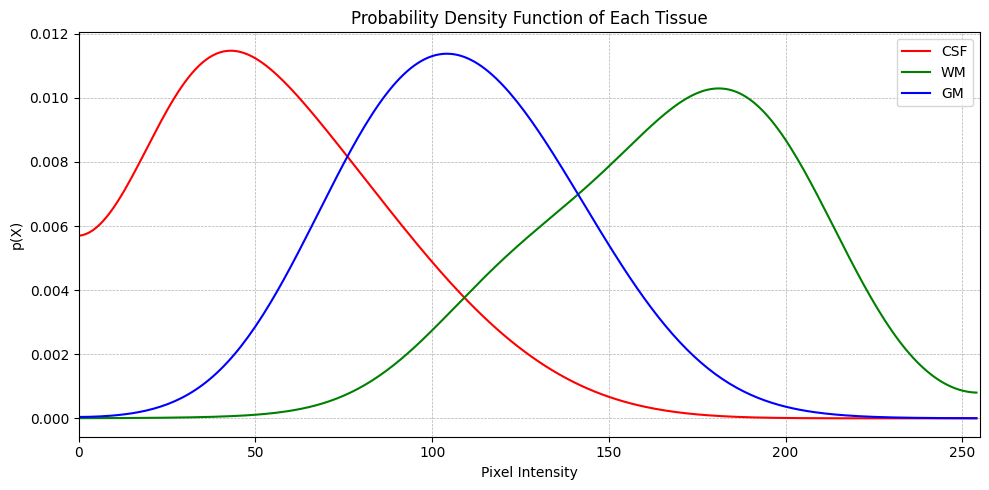

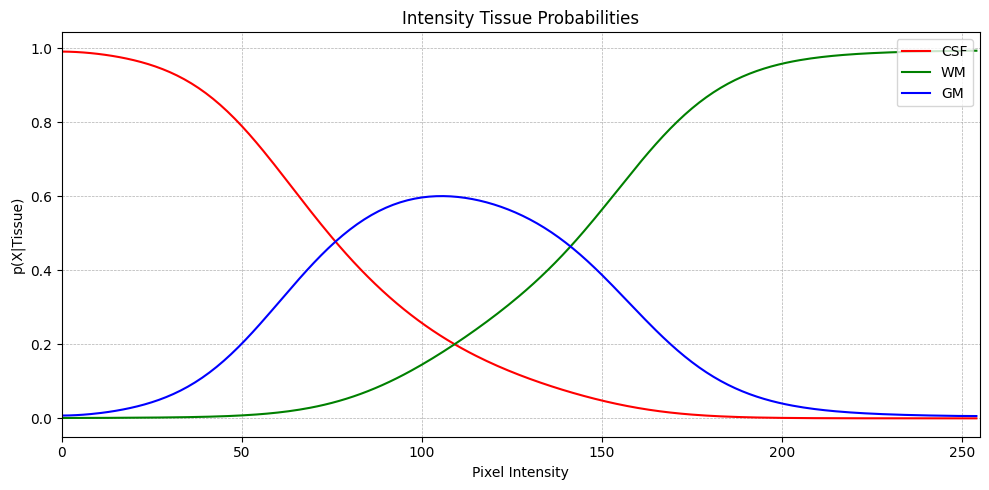

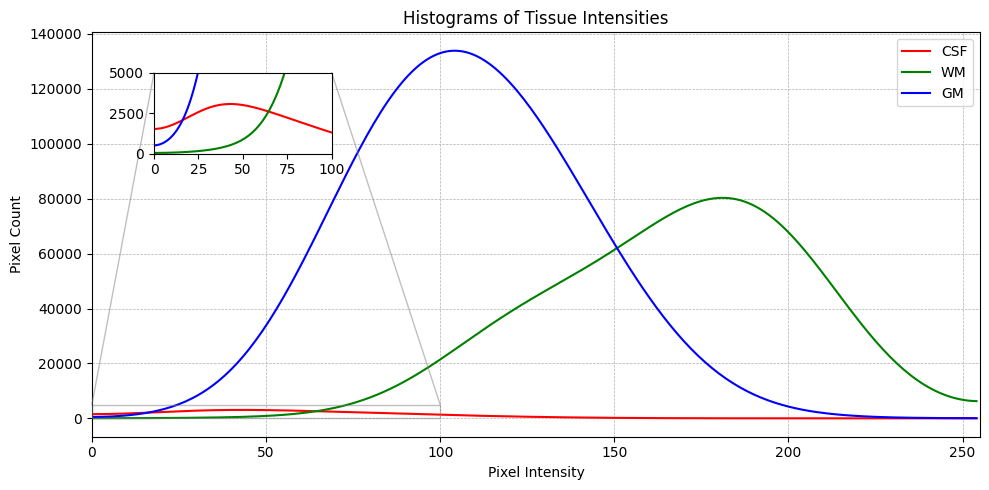

In [24]:
# Paths for registered images and masks
imageFolder = "/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-images"
maskFolder = "/content/drive/MyDrive/MAIA_Work/Semester_3/MIRA/Lab_2/training-set/training-labels"

# Initialize and run the tissue model with registered data
tissueModels = TissueModels(imageFolder, maskFolder)
tissueModels.execute()